In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader
import numpy as np
import random
from pathlib import Path
from tqdm import tqdm

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from typing import Union, Literal
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'

In [41]:
MAIN_PATH = Path("../")
DATA_PATH = MAIN_PATH / "data"
ARTIFACT_PATH = MAIN_PATH / "artifacts"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = os.cpu_count()
EPOCHS = 20
LEARNING_RATE = 1e-4
EPS = 1e-8
CLIP = 1.5

## Prepare Dataset

In [163]:
class MNIST_Dataloader():
    def __init__(
        self,
        data_path: Union[str, Path] = DATA_PATH,
        batch_size: int = 32,
        std_normalize: bool = False,
        ):
        
        self.data_path = data_path
        self.batch_size = batch_size
        
        if std_normalize:
            train_transform = transforms.Compose([
                    transforms.RandomCrop(28, padding = 4),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=0.5, std=0.5)
                ])
            test_transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean=0.5, std=0.5)
                                                ])
        else:
            train_transform = transforms.Compose([
                    transforms.RandomCrop(28, padding = 4),
                    transforms.ToTensor(),
                ])
            test_transform = transforms.Compose([transforms.ToTensor(),
                                                ])

        self.train_dataset = datasets.MNIST(data_path, download = True, train = True, transform = train_transform)
        self.test_dataset = datasets.MNIST(data_path, download = True, train = False, transform = test_transform)
        
    def train_loader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, num_workers=NUM_WORKERS, pin_memory=True)
    
    def test_loader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

## Models

In [172]:
class BaseVAE(nn.Module):
    def __init__(
        self,
        input_size: int = 784,
        common_size: int = 400,
        hidden_size: int = 128,
        activation: Literal["Tanh","Sigmoid"] = "Tanh",
    ):

        super(BaseVAE, self).__init__()
        self.hidden_size = hidden_size
        self.common_size = common_size
        self.flatten = nn.Flatten()
        self.encoder = nn.Linear(input_size, common_size)
        self.mean_fc = nn.Linear(common_size, hidden_size)
        self.var_fc = nn.Linear(common_size, hidden_size)
        self.decoder = nn.Sequential(nn.Linear(hidden_size, common_size), nn.ReLU(),
                                     nn.Linear(common_size, input_size))
        # self.decode_fc = nn.Linear(hidden_size, common_size)
        # self.out_fc = nn.Linear(common_size, input_size)
        self.activation = getattr(nn, activation)()
        
    def encode(self, flattened_inputs: torch.tensor) -> torch.tensor:

        x = F.relu(self.encoder(flattened_inputs))
        mu = self.mean_fc(x)
        log_var = self.var_fc(x)
        return mu, log_var
    
    def reparameterize(self, mu: torch.tensor, log_var: torch.tensor) -> torch.tensor:

        std = torch.exp(0.5*log_var) # Standard deviation of estimated P(z|x)
        eps = torch.randn_like(std) # Sample on z ~ N(0,1)
        z = mu + eps * std # Reparameterize z to on mu & std
        return z
    
    def decode(self, z: torch.tensor) -> torch.tensor:

        out = self.activation(self.decoder(z))
        return out
    
    def forward(self, inputs: torch.tensor):

        x = self.flatten(inputs)
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var
    
    def __str__(self):
        return "VAE"

In [187]:
class Stack(nn.Module):
    def __init__(self, channels, height, width):
        super(Stack, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width

    def forward(self, x):
        return x.view(x.size(0), self.channels, self.height, self.width)

class DeepVAE(BaseVAE):
    def __init__(
        self, input_size: int = 784, common_size: int = 128, hidden_size: int = 128, alpha: float = 1.0,
        activation: Literal["Tanh","Sigmoid"] = "Tanh",
    ):
        super(DeepVAE, self).__init__(input_size, common_size, hidden_size, activation)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
            nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
            nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
            nn.Linear(128, hidden_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
            nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
            nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
            nn.Linear(392, 784),
        )
        
    def __str__(self):
        return "DeepVAE"
    

## Training

### Define Custom Loss function

In [182]:
def BCE_VAE_loss(x_recon: torch.tensor, x: torch.tensor, mu: torch.tensor, log_var: torch.tensor, alpha=1):
    """VAE Loss using BCE for reconstruction loss

    Args:
        x_recon (torch.tensor): _description_
        x (torch.tensor): _description_
        mu (torch.tensor): _description_
        log_var (torch.tensor): _description_
        alpha (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    BCE = F.binary_cross_entropy(x_recon, x.view(x.size(0), -1), reduction="none").sum(dim=1).mean(dim=0)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean(dim=0)
    return alpha*BCE + KLD, BCE, KLD

def MSE_VAE_loss(x_recon: torch.tensor, x: torch.tensor, mu: torch.tensor, log_var: torch.tensor, alpha=1):
    """VAE Loss using MSE for reconstruction loss

    Args:
        x_recon (torch.tensor): _description_
        x (torch.tensor): _description_
        mu (torch.tensor): _description_
        log_var (torch.tensor): _description_
        alpha (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    MSE = nn.MSELoss()(x_recon, x.view(x.size(0), -1))
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean(dim=0)
    return alpha*MSE + KLD, MSE, KLD

In [149]:
x_recon = torch.rand(3,784)
x = torch.rand(3,1,28,28)
mu = torch.rand(3,20)
log_var = torch.rand(3,20)
loss = BCE_VAE_loss
total, recon, kld = loss(x_recon, x, mu, log_var)

### Utils Functions

In [132]:
def save_model(model, path: str):
    """Save Model

    Args:
        model (Callable): Model
        path (str): Path to save ckpt
    """
    torch.save(model.state_dict(), path)
    print(f"Model {str(model)} saved successfully at {path}")


def load_model(model, path: str):
    """Load Model

    Args:
        model (Callable): Model
        path (str): Path to load ckpt
    """
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    print(f"Model {str(model)} loaded successfully from {path}")
    
def seed_everything(seed: int = 2023):
    """Set seed for reproducability"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def plot_images(imgs):
    fig, axs = plt.subplots(nrows=1, ncols=len(imgs), squeeze=True)
    for i in range(len(imgs)):
        img = imgs[i].detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[i].imshow(np.asarray(img))
        axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()
    
def compare_recon(original_images, recon_images):
    fig, axs = plt.subplots(nrows=2, ncols=len(original_images), squeeze=True)
    for i in range(len(original_images)):
        origin_img = original_images[i].detach()
        recon_img = recon_images[i].detach()
        origin_img = torchvision.transforms.functional.to_pil_image(origin_img)
        recon_img = torchvision.transforms.functional.to_pil_image(recon_img)
        axs[0, i].imshow(np.asarray(origin_img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[1, i].imshow(np.asarray(recon_img))
        axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

### Training/Eval Engine Functions

In [183]:
def train(model, loss_function, train_loader, val_loader, no_epochs, learning_rate, alpha = 1, early_stopping = False, patience = 5, save = True, load = False):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
    
    model.to(DEVICE)
    print(f"Training Model on {DEVICE}")
    
    if load:
        ckpt_path = ARTIFACT_PATH / "model_ckpt" / str(model) / "model.pt"
        if not ckpt_path.exists():
            print(f"Ckpt_path for {str(model)} does not exist. Training New Model")
        else:
            load_model(model, ckpt_path)

    best_total = float("inf")
    patience_count = 0
    history = {"total_loss": [], "bce_loss": [], "kld_loss": []}
    
    for epoch in range(no_epochs):
        model.train()
        epoch_loss, recon_epoch_loss, kld_epoch_loss = 0, 0, 0
        tk0 = tqdm(train_loader, total=len(train_loader))
        for batch_idx, (images, _) in enumerate(tk0):
            images = images.to(DEVICE)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(images)
            loss, RECON, KLD = loss_function(recon_batch, images, mu, log_var, alpha = alpha)

            loss.backward()
            epoch_loss += loss.item()
            recon_epoch_loss += RECON.item()
            kld_epoch_loss += KLD.item()
            
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()
            # if (batch_idx + 1) % 100 == 0:
            #     print(f"Train Epoch {epoch + 1} - Total Loss = {loss.item():.4f}, Recon Loss = {RECON.item():.4f}, KLD Loss = {KLD.item():.4f}")
                
        print(f"====> Epoch {epoch + 1} Total Loss = {epoch_loss/len(train_loader):.4f}, Recon Loss = {recon_epoch_loss/len(train_loader):.4f}, KLD Loss =  {kld_epoch_loss/len(train_loader):.4f}")
        
        val_total_loss, val_recon_loss, val_kld_loss = eval(model, loss_function, val_loader, epoch, alpha=alpha)
        scheduler.step(val_total_loss)
        history["total_loss"].append(val_total_loss)
        history["bce_loss"].append(val_recon_loss)
        history["kld_loss"].append(val_kld_loss)
    
        if val_total_loss < best_total:
            print(f"{str(model)}: Val Loss improved at epoch {epoch + 1} from {best_total} to {val_total_loss}")
            best_total = val_total_loss
            patience_count = 0
            if save:
                model_path = ARTIFACT_PATH / "model_ckpt" / str(model)
                if not model_path.exists():
                    model_path.mkdir(parents=True)
                ckpt_path = str(model_path / "model.pt")
                save_model(model, ckpt_path)

        else:
            print(f"{str(model)}: Validation Accuracy from epoch {epoch + 1} did not improve")
            patience_count += 1
            if early_stopping and patience_count == patience:
                print(f"{str(model)}: No val acc improvement for {patience} consecutive epochs. Early Stopped at epoch {epoch + 1}")
        
    return history        
        
def eval(model, loss_function, val_loader, epoch = 0, alpha = 1):
    model.eval()
    with torch.no_grad():
        epoch_loss, recon_epoch_loss, kld_epoch_loss = 0, 0, 0
        for batch_idx, (images, _) in enumerate(val_loader):
            images = images.to(DEVICE)
            recon_batch, mu, log_var = model(images)
            loss, RECON, KLD = loss_function(recon_batch, images, mu, log_var, alpha=alpha)
            epoch_loss += loss.item()
            recon_epoch_loss += RECON.item()
            kld_epoch_loss += KLD.item()
            
            if batch_idx == 0:
                n = min(images.size(0), 8)
                recon_images = recon_batch.view(images.size(0), 1, 28, 28)[:n]
                compare_recon(images[:n], recon_images)
            
    return epoch_loss/len(val_loader), recon_epoch_loss/len(val_loader), kld_epoch_loss/len(val_loader)

### Train on BCELoss + KL Divergence + Sigmoid + Input Data Normalize between 0 & 1

Training Model on cpu


100%|██████████| 1875/1875 [00:22<00:00, 82.75it/s]

====> Epoch 1 Total Loss = 238.6478, Recon Loss = 227.3243, KLD Loss =  11.3235


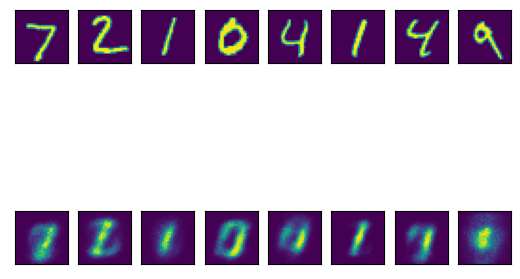

VAE: Val Loss improved at epoch 1 from inf to 196.64970583199693
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:24<00:00, 77.43it/s]

====> Epoch 2 Total Loss = 187.5866, Recon Loss = 168.5651, KLD Loss =  19.0215


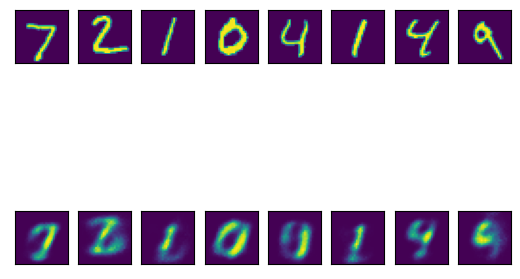

VAE: Val Loss improved at epoch 2 from 196.64970583199693 to 170.10262227896303
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:22<00:00, 81.95it/s]

====> Epoch 3 Total Loss = 172.1309, Recon Loss = 148.1308, KLD Loss =  24.0001


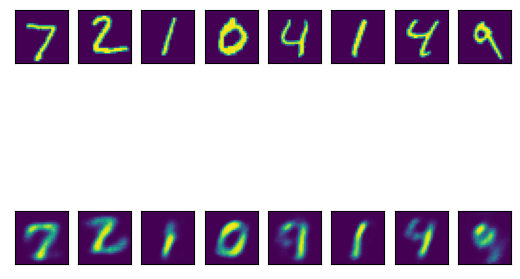

VAE: Val Loss improved at epoch 3 from 170.10262227896303 to 160.7333830812107
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 79.14it/s]

====> Epoch 4 Total Loss = 164.4899, Recon Loss = 138.2219, KLD Loss =  26.2679


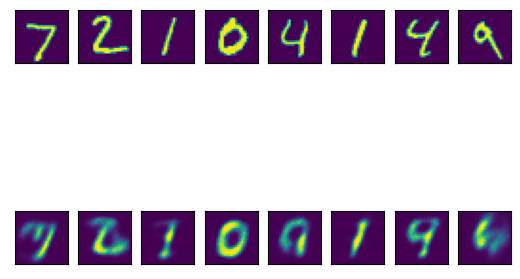

VAE: Val Loss improved at epoch 4 from 160.7333830812107 to 154.49203203585202
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 80.71it/s]

====> Epoch 5 Total Loss = 158.5165, Recon Loss = 130.5768, KLD Loss =  27.9398


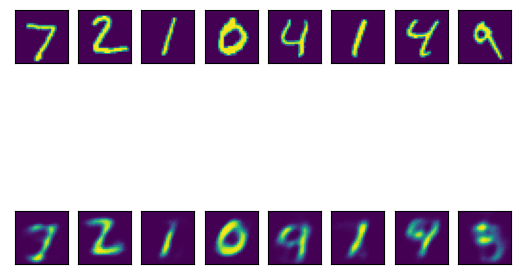

VAE: Val Loss improved at epoch 5 from 154.49203203585202 to 149.27682270866615
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 80.54it/s]

====> Epoch 6 Total Loss = 153.7992, Recon Loss = 124.6685, KLD Loss =  29.1307


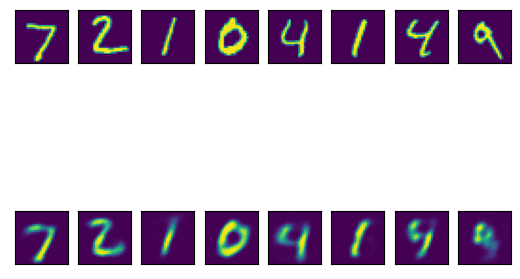

VAE: Val Loss improved at epoch 6 from 149.27682270866615 to 145.0752655858049
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 79.30it/s]

====> Epoch 7 Total Loss = 149.7276, Recon Loss = 119.8714, KLD Loss =  29.8562


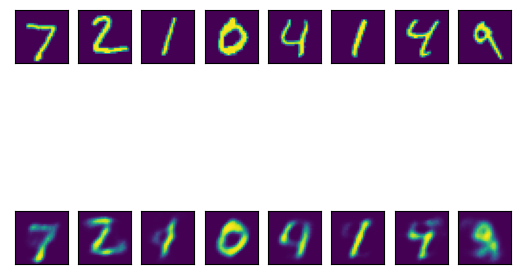

VAE: Val Loss improved at epoch 7 from 145.0752655858049 to 141.62218360779005
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 79.65it/s]

====> Epoch 8 Total Loss = 145.9386, Recon Loss = 115.6689, KLD Loss =  30.2698


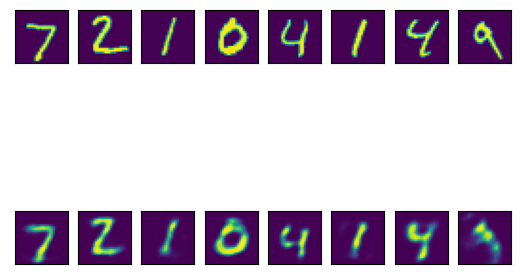

VAE: Val Loss improved at epoch 8 from 141.62218360779005 to 138.76381186098337
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 78.51it/s]

====> Epoch 9 Total Loss = 142.7957, Recon Loss = 112.2372, KLD Loss =  30.5585


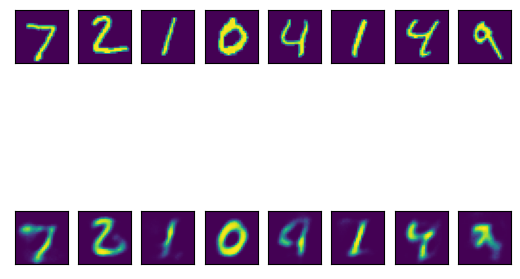

VAE: Val Loss improved at epoch 9 from 138.76381186098337 to 135.99544537334015
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 79.39it/s]

====> Epoch 10 Total Loss = 140.0488, Recon Loss = 109.2780, KLD Loss =  30.7707


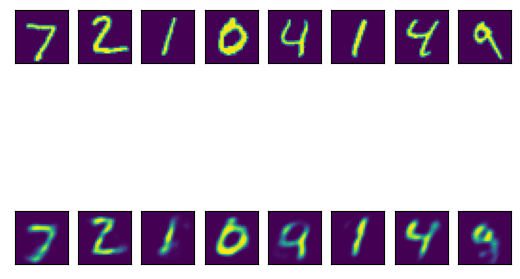

VAE: Val Loss improved at epoch 10 from 135.99544537334015 to 133.43539019209888
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:25<00:00, 73.43it/s]

====> Epoch 11 Total Loss = 137.6110, Recon Loss = 106.7075, KLD Loss =  30.9034


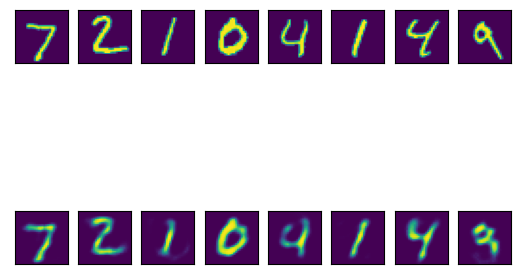

VAE: Val Loss improved at epoch 11 from 133.43539019209888 to 131.41745182805167
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 78.54it/s]

====> Epoch 12 Total Loss = 135.5375, Recon Loss = 104.4966, KLD Loss =  31.0409


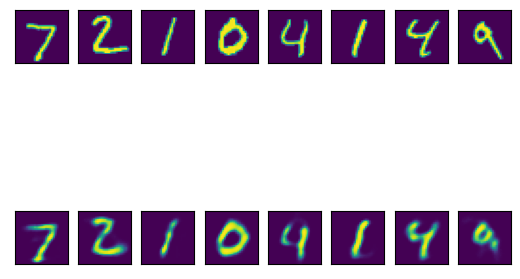

VAE: Val Loss improved at epoch 12 from 131.41745182805167 to 129.71555701307597
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 79.49it/s]

====> Epoch 13 Total Loss = 133.7609, Recon Loss = 102.6142, KLD Loss =  31.1468


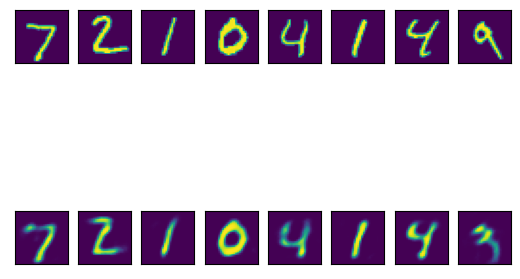

VAE: Val Loss improved at epoch 13 from 129.71555701307597 to 128.2127829603494
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 78.65it/s]

====> Epoch 14 Total Loss = 132.3021, Recon Loss = 101.0165, KLD Loss =  31.2856


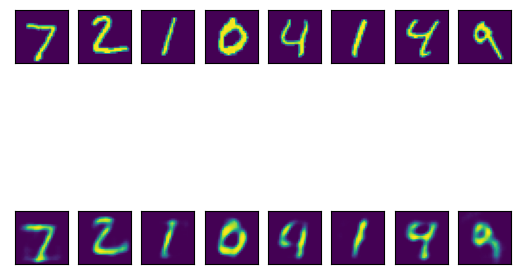

VAE: Val Loss improved at epoch 14 from 128.2127829603494 to 126.89334016257581
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:23<00:00, 78.90it/s]

====> Epoch 15 Total Loss = 131.0096, Recon Loss = 99.5507, KLD Loss =  31.4589


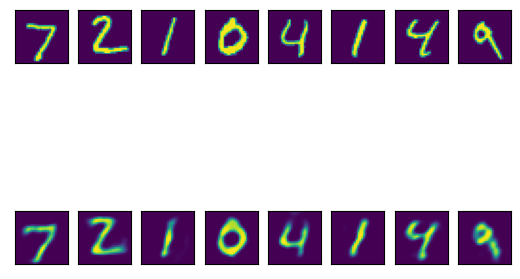

VAE: Val Loss improved at epoch 15 from 126.89334016257581 to 125.6558902728291
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


In [184]:
bce_model = BaseVAE(activation="Sigmoid")
loss = BCE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=False)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(bce_model, loss, train_loader, test_loader, 15, LEARNING_RATE, early_stopping = False, patience = 5, save = True, load = False)

### Train on BCELoss + KL Divergence + Sigmoid + Input Data Normalize between -1 & 1

Training Model on cpu


100%|██████████| 1875/1875 [00:23<00:00, 78.51it/s]

====> Epoch 1 Total Loss = -22132.1196, Recon Loss = -22327.7808, KLD Loss =  195.6612


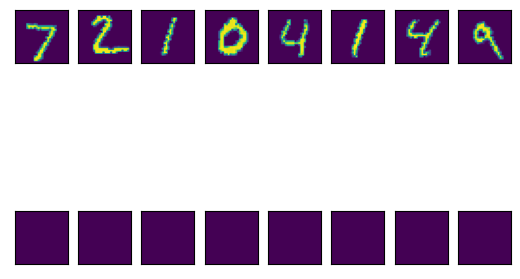

VAE: Val Loss improved at epoch 1 from inf to -26714.56930785743
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:25<00:00, 72.97it/s]

====> Epoch 2 Total Loss = -34226.6214, Recon Loss = -34238.9495, KLD Loss =  12.3280


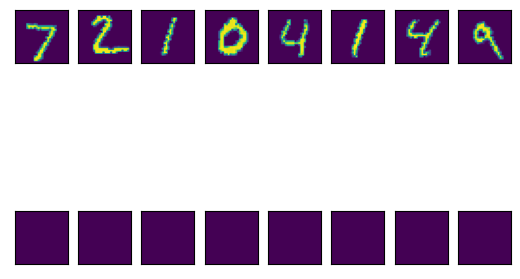

VAE: Val Loss improved at epoch 2 from -26714.56930785743 to -43180.80532398163
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:27<00:00, 68.53it/s]

====> Epoch 3 Total Loss = -49408.9702, Recon Loss = -49428.9476, KLD Loss =  19.9775


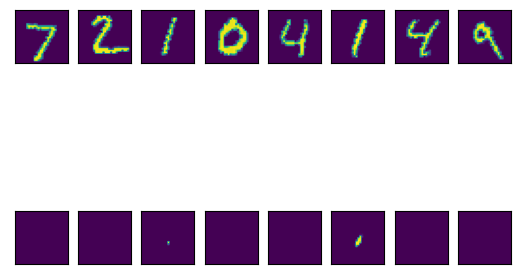

VAE: Val Loss improved at epoch 3 from -43180.80532398163 to -49579.710475738815
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:27<00:00, 67.75it/s]

====> Epoch 4 Total Loss = -51793.4724, Recon Loss = -51810.6371, KLD Loss =  17.1647


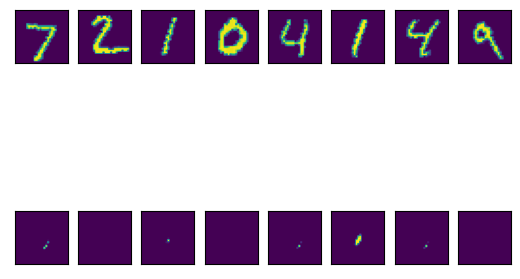

VAE: Validation Accuracy from epoch 4 did not improve


100%|██████████| 1875/1875 [00:27<00:00, 67.33it/s]

====> Epoch 5 Total Loss = -52866.9524, Recon Loss = -52890.0942, KLD Loss =  23.1418


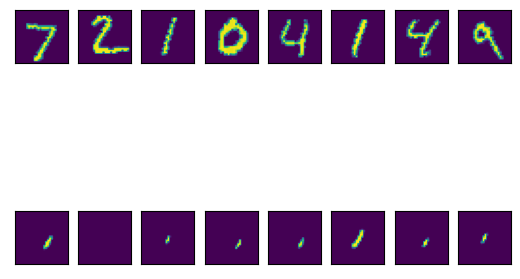

VAE: Val Loss improved at epoch 5 from -49579.710475738815 to -52984.36544029553
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:27<00:00, 68.48it/s]

====> Epoch 6 Total Loss = -54543.4030, Recon Loss = -54570.7613, KLD Loss =  27.3584


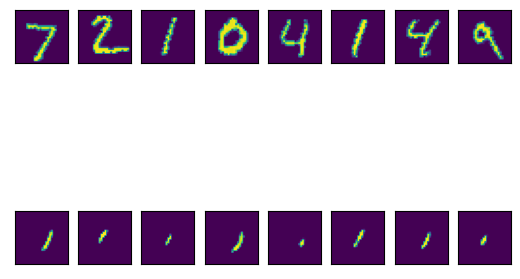

VAE: Val Loss improved at epoch 6 from -52984.36544029553 to -54010.46377046725
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:28<00:00, 64.76it/s]

====> Epoch 7 Total Loss = -55632.2003, Recon Loss = -55665.4927, KLD Loss =  33.2924


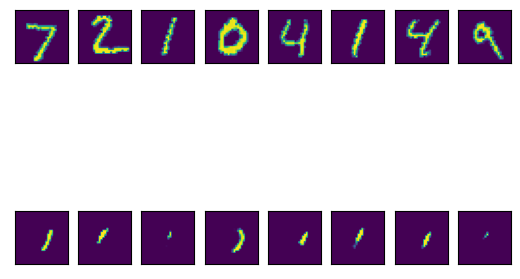

VAE: Val Loss improved at epoch 7 from -54010.46377046725 to -55460.7470297524
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:28<00:00, 66.39it/s]

====> Epoch 8 Total Loss = -56466.1801, Recon Loss = -56508.7841, KLD Loss =  42.6040


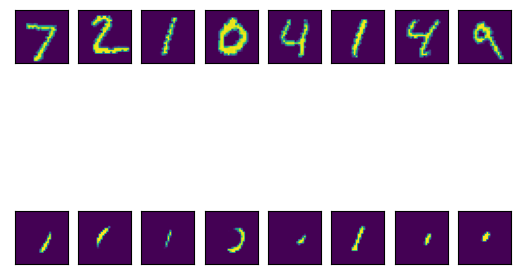

VAE: Val Loss improved at epoch 8 from -55460.7470297524 to -56844.37660992412
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:28<00:00, 65.91it/s]

====> Epoch 9 Total Loss = -57103.2925, Recon Loss = -57149.8556, KLD Loss =  46.5631


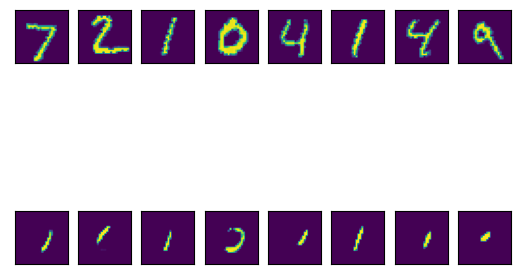

VAE: Validation Accuracy from epoch 9 did not improve


100%|██████████| 1875/1875 [00:28<00:00, 65.90it/s]

====> Epoch 10 Total Loss = -57423.8969, Recon Loss = -57476.6388, KLD Loss =  52.7418


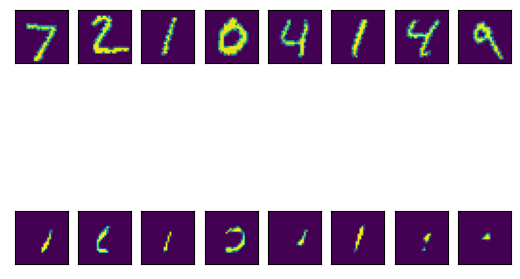

VAE: Val Loss improved at epoch 10 from -56844.37660992412 to -57332.2421875
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:27<00:00, 67.62it/s]

====> Epoch 11 Total Loss = -57767.6784, Recon Loss = -57827.2332, KLD Loss =  59.5548


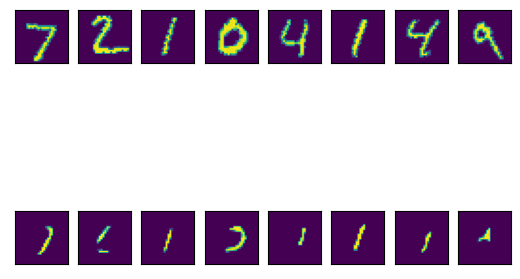

VAE: Validation Accuracy from epoch 11 did not improve


100%|██████████| 1875/1875 [00:28<00:00, 64.91it/s]

====> Epoch 12 Total Loss = -58065.7862, Recon Loss = -58131.0120, KLD Loss =  65.2258


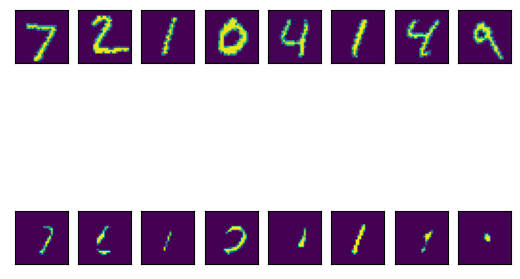

VAE: Val Loss improved at epoch 12 from -57332.2421875 to -57770.35997404153
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:28<00:00, 65.43it/s]

====> Epoch 13 Total Loss = -58355.0262, Recon Loss = -58425.4181, KLD Loss =  70.3918


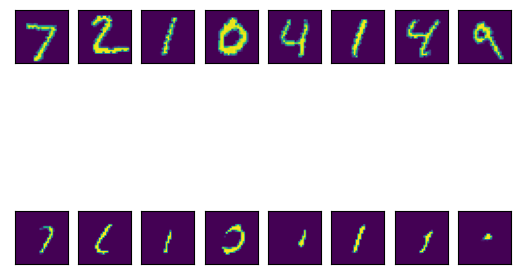

VAE: Val Loss improved at epoch 13 from -57770.35997404153 to -58420.86935902556
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:28<00:00, 65.05it/s]

====> Epoch 14 Total Loss = -58580.6228, Recon Loss = -58654.7332, KLD Loss =  74.1104


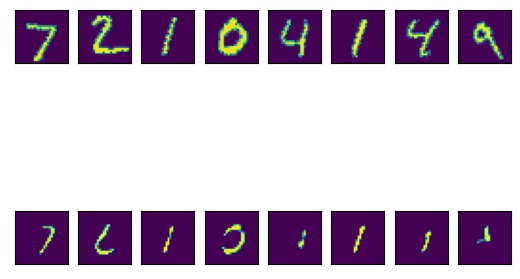

VAE: Val Loss improved at epoch 14 from -58420.86935902556 to -58611.51643620207
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


100%|██████████| 1875/1875 [00:28<00:00, 66.40it/s]

====> Epoch 15 Total Loss = -58766.1376, Recon Loss = -58843.0678, KLD Loss =  76.9302


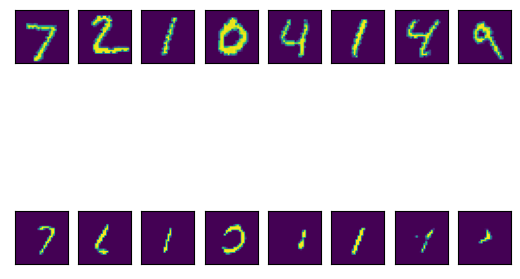

VAE: Val Loss improved at epoch 15 from -58611.51643620207 to -58956.072708666135
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


In [185]:
bce_model = BaseVAE(activation="Sigmoid")
loss = BCE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=True)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(bce_model, loss, train_loader, test_loader, 15, 1e-4, early_stopping = False, patience = 5, save = True, load = False)

### Train on MSE Loss and KL Divergence

#### Alpha = 1 (MSE Loss & KL Divergence equal weights)

Training Model on cpu


100%|██████████| 1875/1875 [00:34<00:00, 53.77it/s]

====> Epoch 1 Total Loss = 0.3945, Recon Loss = 0.3354, KLD Loss =  0.0591


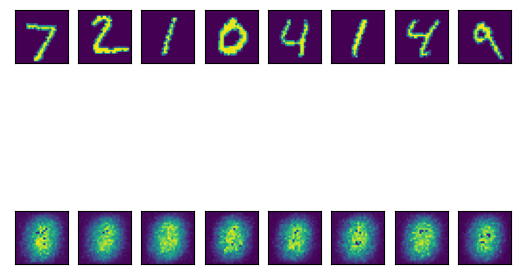

DeepVAE: Val Loss improved at epoch 1 from inf to 0.29162858678890874
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:35<00:00, 52.82it/s]

====> Epoch 2 Total Loss = 0.3176, Recon Loss = 0.3172, KLD Loss =  0.0004


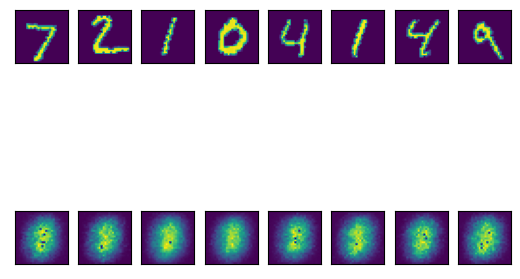

DeepVAE: Val Loss improved at epoch 2 from 0.29162858678890874 to 0.2880120116015212
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 55.75it/s]

====> Epoch 3 Total Loss = 0.3158, Recon Loss = 0.3157, KLD Loss =  0.0001


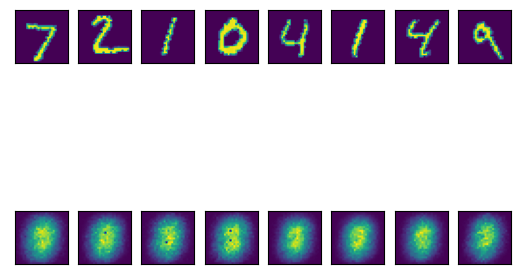

DeepVAE: Val Loss improved at epoch 3 from 0.2880120116015212 to 0.28774421426434865
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.61it/s]

====> Epoch 4 Total Loss = 0.3149, Recon Loss = 0.3148, KLD Loss =  0.0000


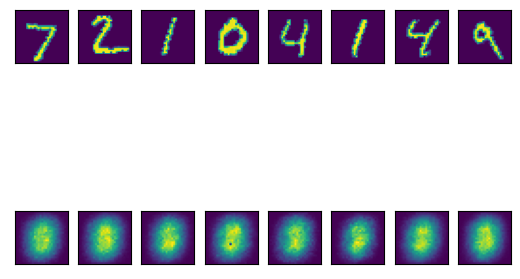

DeepVAE: Val Loss improved at epoch 4 from 0.28774421426434865 to 0.2870166703058889
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.87it/s]

====> Epoch 5 Total Loss = 0.3147, Recon Loss = 0.3146, KLD Loss =  0.0000


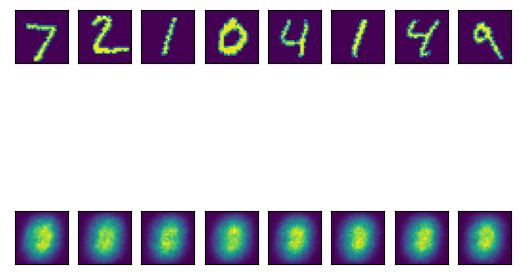

DeepVAE: Validation Accuracy from epoch 5 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 54.12it/s]

====> Epoch 6 Total Loss = 0.3143, Recon Loss = 0.3142, KLD Loss =  0.0000


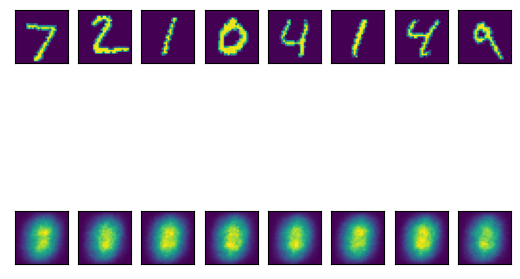

DeepVAE: Validation Accuracy from epoch 6 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 55.12it/s]

====> Epoch 7 Total Loss = 0.3141, Recon Loss = 0.3141, KLD Loss =  0.0000


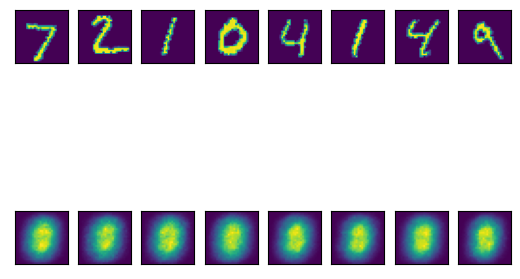

DeepVAE: Validation Accuracy from epoch 7 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 54.80it/s]

====> Epoch 8 Total Loss = 0.3140, Recon Loss = 0.3140, KLD Loss =  0.0000


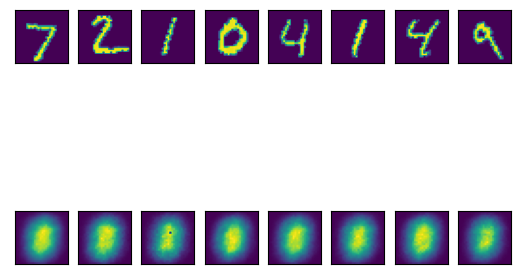

DeepVAE: Val Loss improved at epoch 8 from 0.2870166703058889 to 0.2868710665371471
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.38it/s]

====> Epoch 9 Total Loss = 0.3137, Recon Loss = 0.3137, KLD Loss =  0.0000


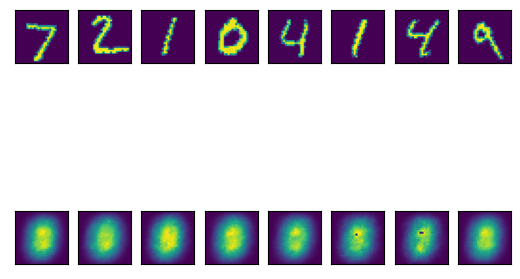

DeepVAE: Val Loss improved at epoch 9 from 0.2868710665371471 to 0.2867204776872842
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.99it/s]

====> Epoch 10 Total Loss = 0.3137, Recon Loss = 0.3137, KLD Loss =  0.0000


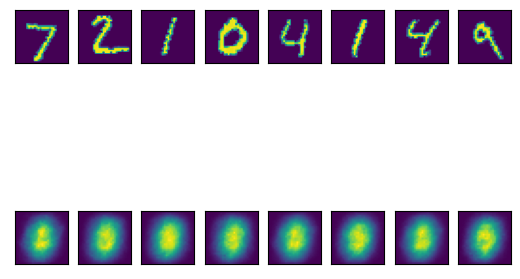

DeepVAE: Val Loss improved at epoch 10 from 0.2867204776872842 to 0.28589359849405743
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.36it/s]

====> Epoch 11 Total Loss = 0.3139, Recon Loss = 0.3139, KLD Loss =  0.0000


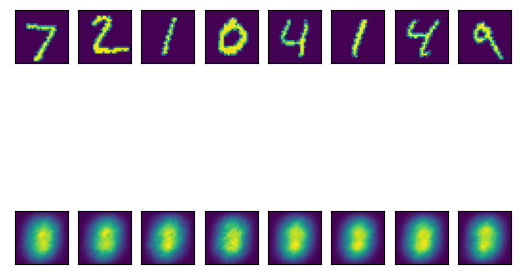

DeepVAE: Val Loss improved at epoch 11 from 0.28589359849405743 to 0.285725288831007
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.32it/s]

====> Epoch 12 Total Loss = 0.3138, Recon Loss = 0.3138, KLD Loss =  0.0000


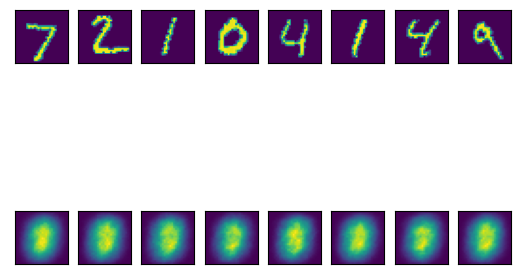

DeepVAE: Validation Accuracy from epoch 12 did not improve


100%|██████████| 1875/1875 [00:33<00:00, 55.41it/s]

====> Epoch 13 Total Loss = 0.3136, Recon Loss = 0.3136, KLD Loss =  0.0000


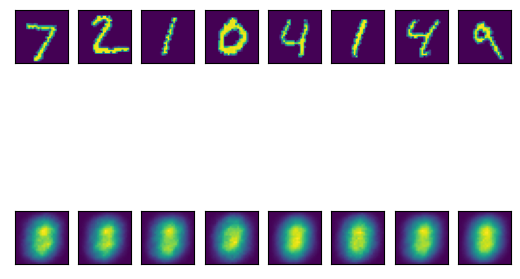

DeepVAE: Validation Accuracy from epoch 13 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 55.05it/s]

====> Epoch 14 Total Loss = 0.3136, Recon Loss = 0.3136, KLD Loss =  0.0000


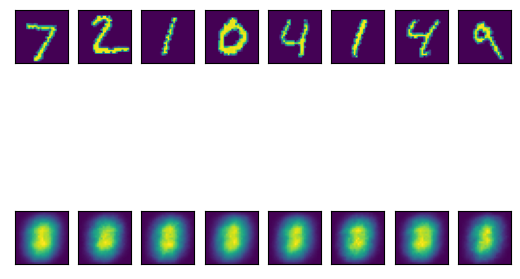

DeepVAE: Validation Accuracy from epoch 14 did not improve


100%|██████████| 1875/1875 [00:33<00:00, 55.67it/s]

====> Epoch 15 Total Loss = 0.3136, Recon Loss = 0.3136, KLD Loss =  0.0000


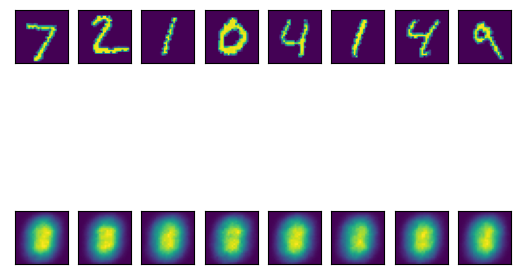

DeepVAE: Val Loss improved at epoch 15 from 0.285725288831007 to 0.28520462507257066
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 53.90it/s]

====> Epoch 16 Total Loss = 0.3136, Recon Loss = 0.3136, KLD Loss =  0.0000


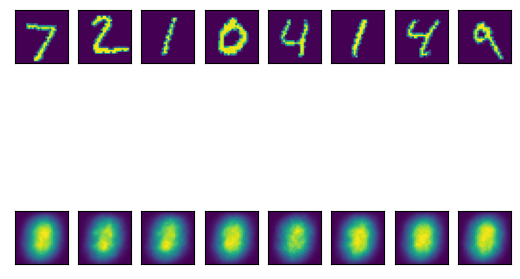

DeepVAE: Validation Accuracy from epoch 16 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 54.21it/s]

====> Epoch 17 Total Loss = 0.3136, Recon Loss = 0.3136, KLD Loss =  0.0000


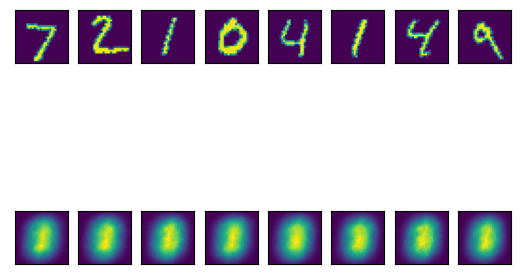

DeepVAE: Val Loss improved at epoch 17 from 0.28520462507257066 to 0.28485855879113314
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 55.49it/s]

====> Epoch 18 Total Loss = 0.3136, Recon Loss = 0.3136, KLD Loss =  0.0000


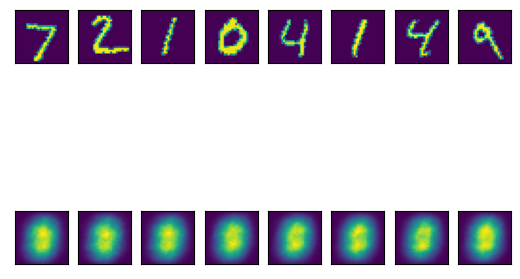

DeepVAE: Validation Accuracy from epoch 18 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 54.28it/s]

====> Epoch 19 Total Loss = 0.3135, Recon Loss = 0.3135, KLD Loss =  0.0000


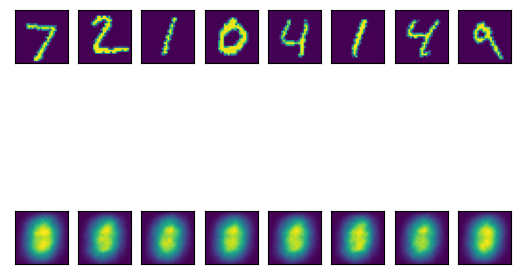

DeepVAE: Validation Accuracy from epoch 19 did not improve


100%|██████████| 1875/1875 [00:34<00:00, 54.89it/s]

====> Epoch 20 Total Loss = 0.3133, Recon Loss = 0.3133, KLD Loss =  0.0000


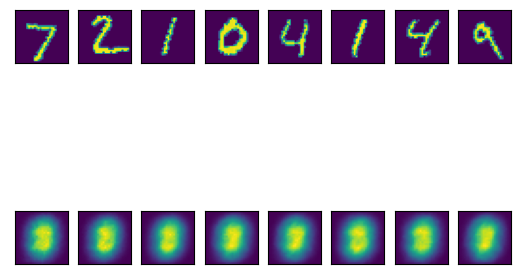

DeepVAE: Validation Accuracy from epoch 20 did not improve


In [192]:
mse_model = DeepVAE(activation="Tanh")
loss = MSE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=True)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(mse_model, loss, train_loader, test_loader, 20, LEARNING_RATE,
                early_stopping = False, patience = 5, save = True, load = False, alpha=1)

#### Alpha = 10 (MLELoss = 1/10 KLDLoss)

Training Model on cpu


100%|██████████| 1875/1875 [00:25<00:00, 73.50it/s]

====> Epoch 1 Total Loss = 3.3609, Recon Loss = 0.3340, KLD Loss =  0.0209



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1e39c820d0>
Traceback (most recent call last):
  File "/mnt/c/Users/QUAN/desktop/gan/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/mnt/c/Users/QUAN/desktop/gan/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


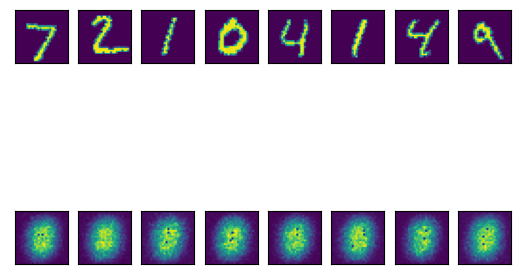

VAE: Val Loss improved at epoch 1 from inf to 2.8936942073102956
Model VAE saved successfully at ../artifacts/model_ckpt/VAE/model.pt


  1%|          | 16/1875 [00:00<00:51, 35.96it/s]

In [195]:
mse_model = BaseVAE(activation="Tanh")
loss = MSE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=True)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(mse_model, loss, train_loader, test_loader, 10, LEARNING_RATE,
                early_stopping = False, patience = 5, save = True, load = False, alpha=10)

#### Alpha = 100 (MLELoss = 1/10 KLDLoss)

In [ ]:
mse_model = DeepVAE(activation="Tanh")
loss = MSE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=True)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(mse_model, loss, train_loader, test_loader, 20, LEARNING_RATE,
                early_stopping = False, patience = 5, save = True, load = False, alpha=100)

#### Alpha = 1000 (MLELoss = 1/10 KLDLoss)

Training Model on cpu


100%|██████████| 1875/1875 [00:32<00:00, 58.01it/s]

====> Epoch 1 Total Loss = 273.7014, Recon Loss = 0.2590, KLD Loss =  14.7431


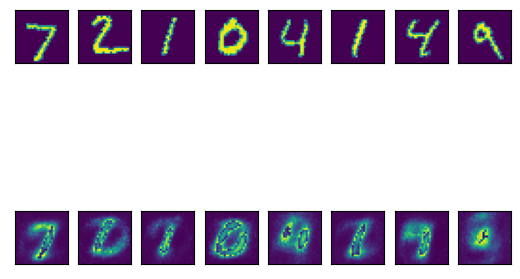

DeepVAE: Val Loss improved at epoch 1 from inf to 206.95707883012182
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 56.71it/s]

====> Epoch 2 Total Loss = 209.4370, Recon Loss = 0.1848, KLD Loss =  24.6488


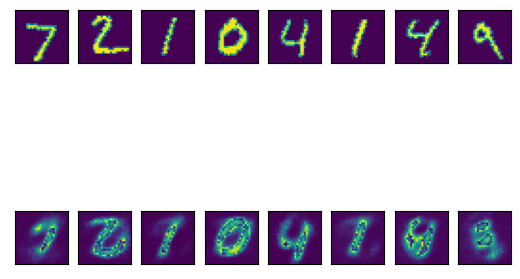

DeepVAE: Val Loss improved at epoch 2 from 206.95707883012182 to 177.59308763205433
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:32<00:00, 56.92it/s]

====> Epoch 3 Total Loss = 190.1426, Recon Loss = 0.1620, KLD Loss =  28.1030


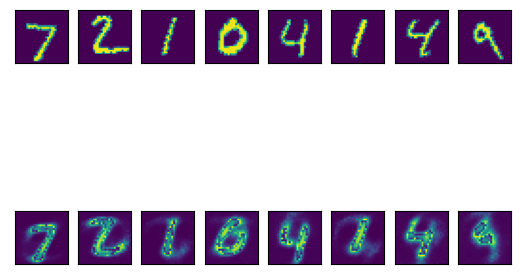

DeepVAE: Val Loss improved at epoch 3 from 177.59308763205433 to 162.08499754884372
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 56.04it/s]

====> Epoch 4 Total Loss = 176.9874, Recon Loss = 0.1479, KLD Loss =  29.1016


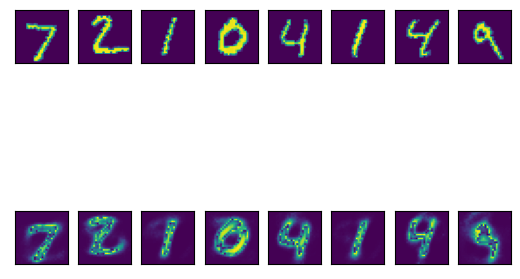

DeepVAE: Val Loss improved at epoch 4 from 162.08499754884372 to 151.5670337128563
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 55.96it/s]

====> Epoch 5 Total Loss = 165.7965, Recon Loss = 0.1364, KLD Loss =  29.3776


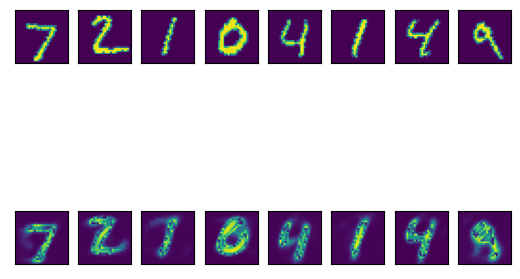

DeepVAE: Val Loss improved at epoch 5 from 151.5670337128563 to 139.23454635668867
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 56.15it/s]

====> Epoch 6 Total Loss = 156.4409, Recon Loss = 0.1273, KLD Loss =  29.1294


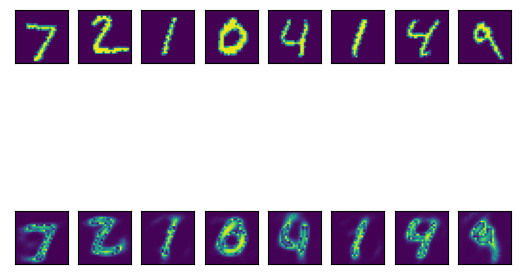

DeepVAE: Val Loss improved at epoch 6 from 139.23454635668867 to 130.91552244436247
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:33<00:00, 55.90it/s]

====> Epoch 7 Total Loss = 148.6110, Recon Loss = 0.1197, KLD Loss =  28.9266


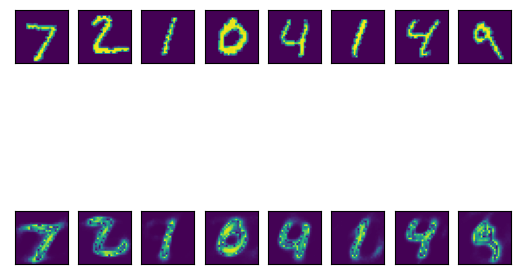

DeepVAE: Val Loss improved at epoch 7 from 130.91552244436247 to 124.4536389481907
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


100%|██████████| 1875/1875 [00:34<00:00, 54.32it/s]

====> Epoch 8 Total Loss = 143.3372, Recon Loss = 0.1143, KLD Loss =  29.0005


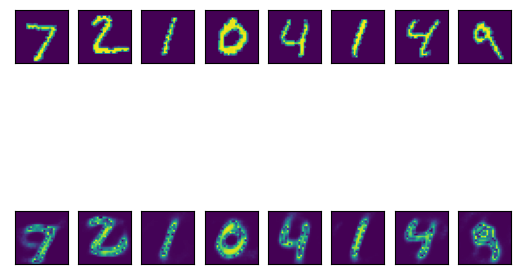

DeepVAE: Val Loss improved at epoch 8 from 124.4536389481907 to 119.48053846267847
Model DeepVAE saved successfully at ../artifacts/model_ckpt/DeepVAE/model.pt


 39%|███▉      | 738/1875 [00:14<00:21, 52.54it/s]


KeyboardInterrupt: 

In [ ]:
mse_model = DeepVAE(activation="Tanh")
loss = MSE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=True)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(mse_model, loss, train_loader, test_loader, 50, LEARNING_RATE,
                early_stopping = False, patience = 5, save = True, load = False, alpha=1000)

## Inference

### Inference on BCE loss

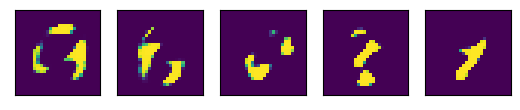

In [136]:
latent_size = 20
sample_number = 10
z = torch.randn(5, latent_size)
recon_images = model.decode(z).view(z.size(0), 1, 28, 28)
plot_images(recon_images)